# ePSproc function verification & tests
19/06/20

For LF and AF calculations, trying to get to the bottom of issues with magnitudes and/or phases and/or formalism differences with raw ePS matrix elements.

## Set up

In [7]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc or time
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc
import time

# Package fns.
# For module testing, include path to module here
import sys
import os
# modPath = r'D:\code\github\ePSproc'  # Win test machine
modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc, geomUtils

## Clebsch Gordan coeffs

Numerical defn. from Moble's Spherical Functions, https://github.com/moble/spherical_functions/blob/master/spherical_functions/recursions/wigner3j.py

`def clebsch_gordan(j_1, m_1, j_2, m_2, j_3, m_3)`

`(-1.)**(j_1-j_2+m_3) * math.sqrt(2*j_3+1) * Wigner3j(j_1, j_2, j_3, m_1, m_2, -m_3)`

Initially try implementing this directly (based on modified 3j function outputs), then implement for ePS BLM calculations to match & check against published formalism.

In [36]:
# Set QNs up to Lmax (allowed M only)
Lmax = 1
QNs = geomUtils.genllL(Lmax = Lmax)

In [37]:
# Set CG function
def CG(QNs):
    """
    Basic CG from 3j calculation, from table of input QNs (corresponding to CG term defn.).
    
    QNs = [l, lp, L, m, mp, M]
    """
    
    # Set phase convention, CG(M3) > 3j(-M3)
    QNs[:,5] *= -1
    
    # Generate some 3j values (Xarray form) from supplied QNs
    w3j = geomCalc.w3jTable(QNs = QNs, form = 'xarray', nonzeroFlag = True)
    
    # Phase and degen terms
    CGphase = np.power(-1, np.abs(w3j.l - w3j.lp + w3j.M))
    CGdegen = np.sqrt(2*w3j.L + 1)
    
    return CGphase * CGdegen * w3j

In [38]:
# Compute 3js
w3jX = geomCalc.w3jTable(QNs = QNs, form = 'xarray', nonzeroFlag = True)

# Compute CGs
CGX = CG(QNs)

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Plotting data (No filename), pType=r, thres=0.01, with Seaborn
Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


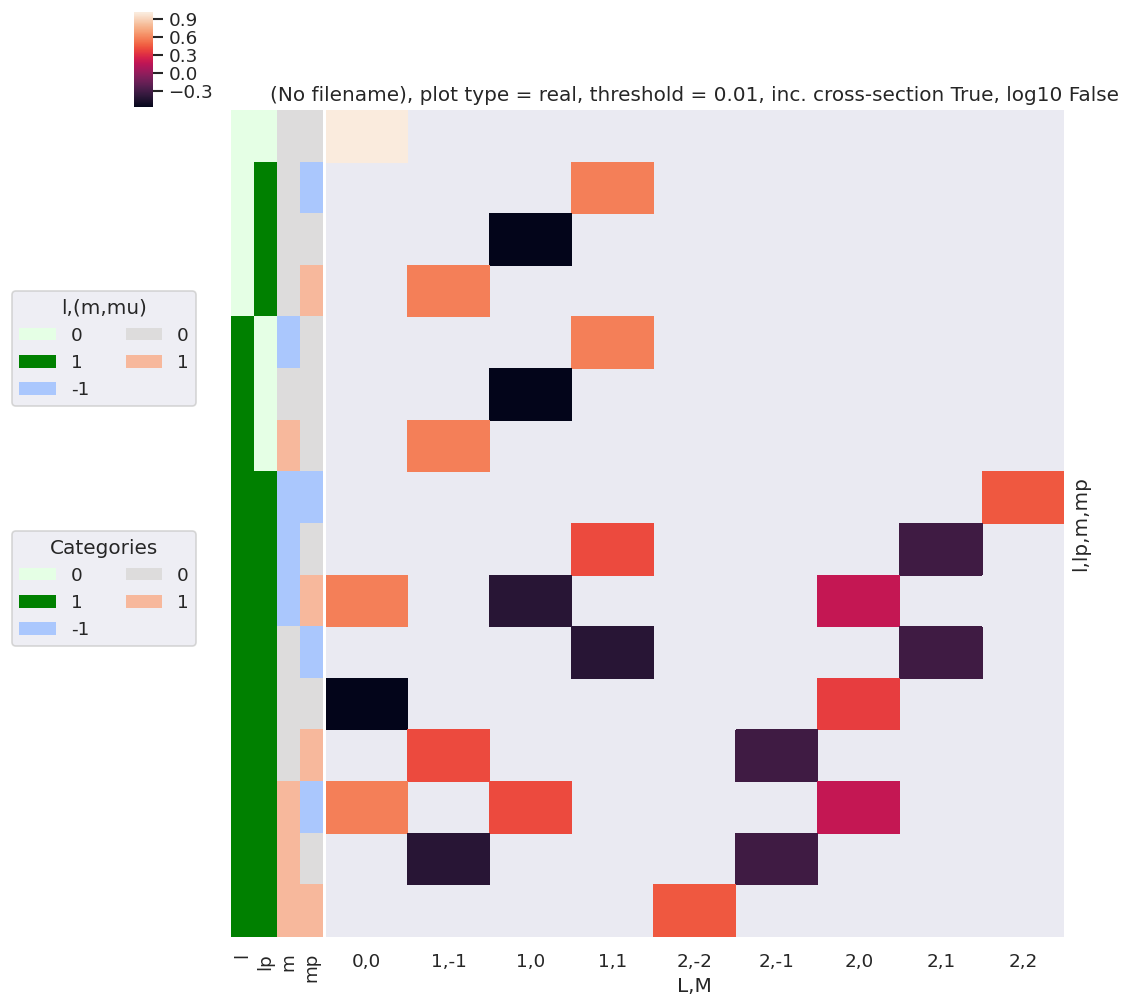

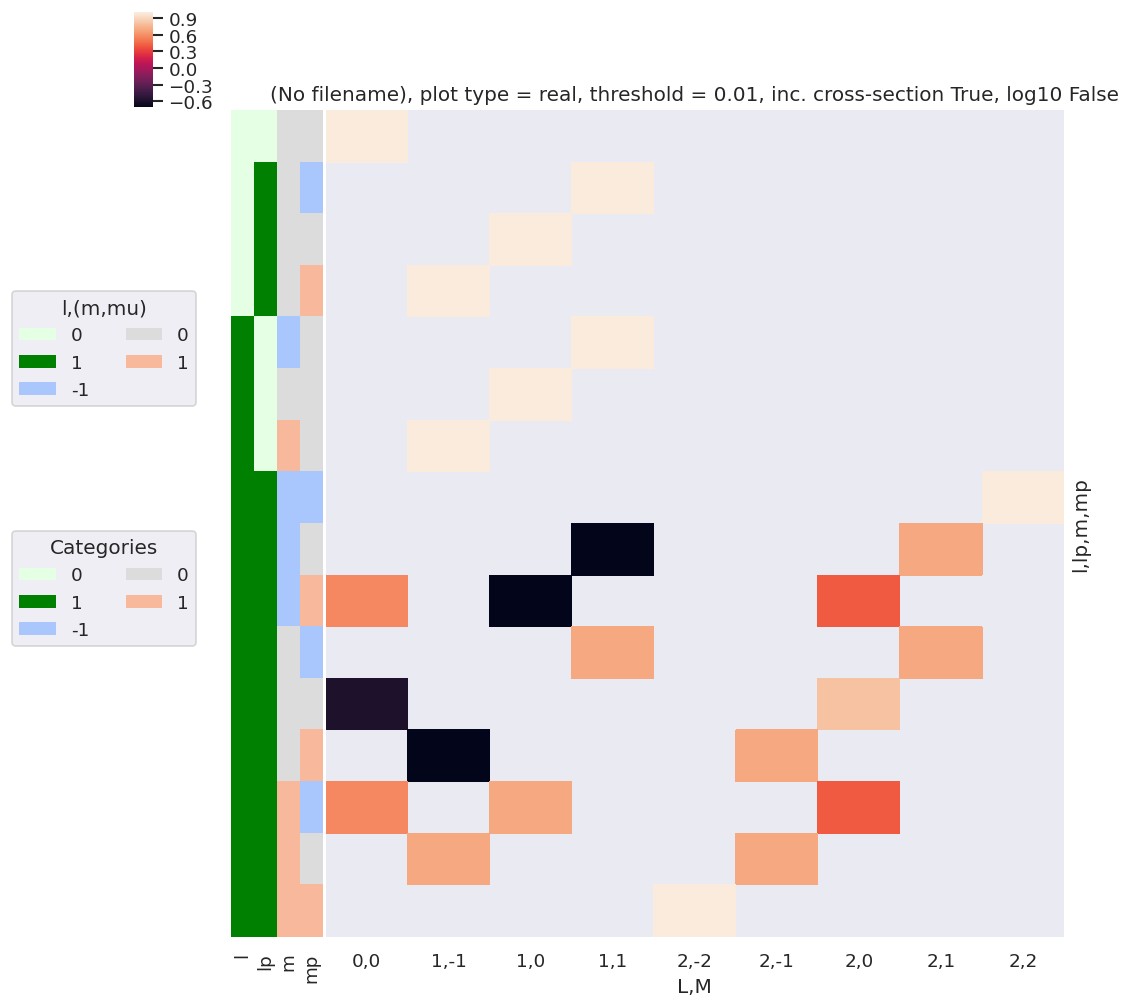

In [39]:
# Set parameters to restack the Xarray into (L,M) pairs
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3jX, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(CGX, xDim=xDim, pType = 'r')

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=None, with Seaborn
Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=None, with Seaborn


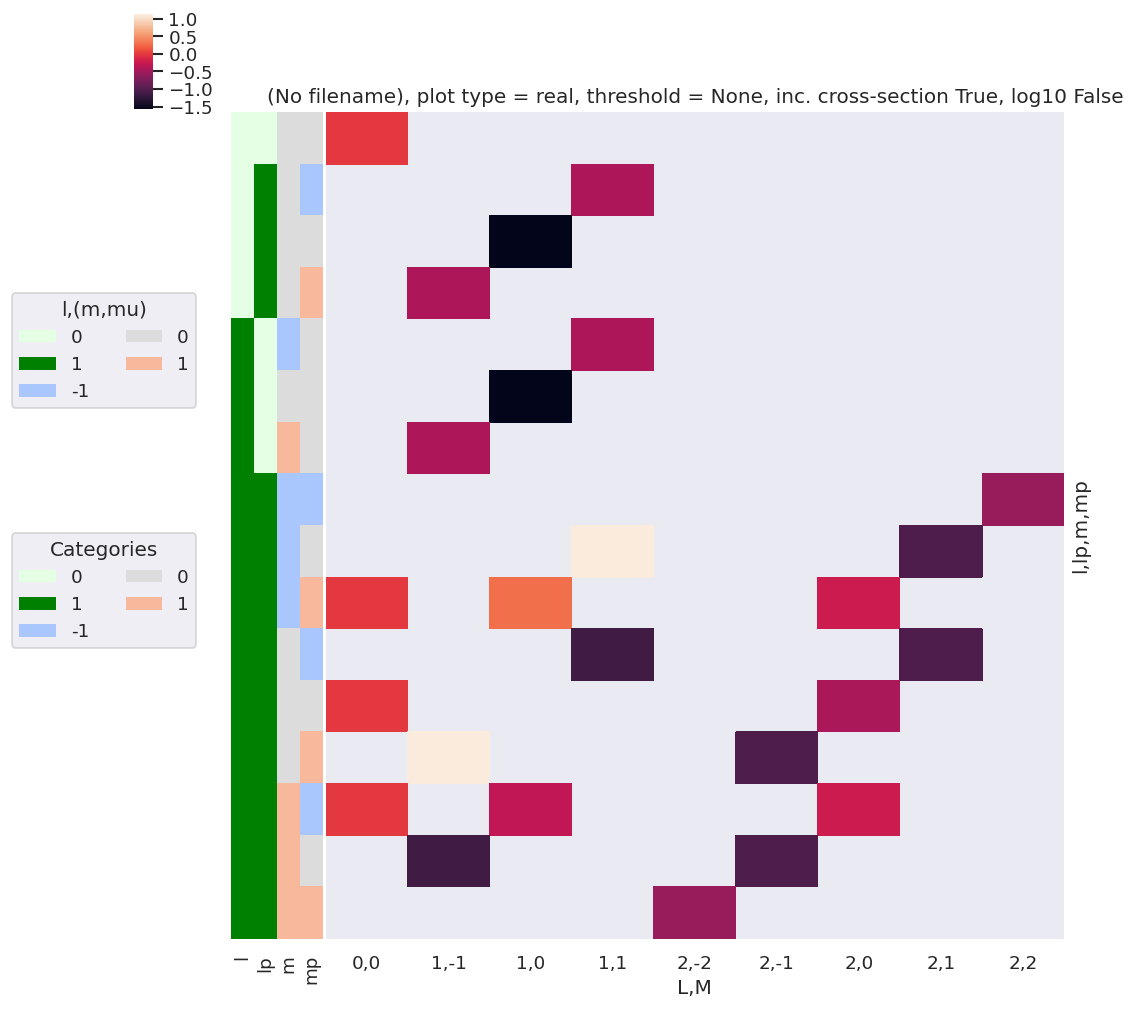

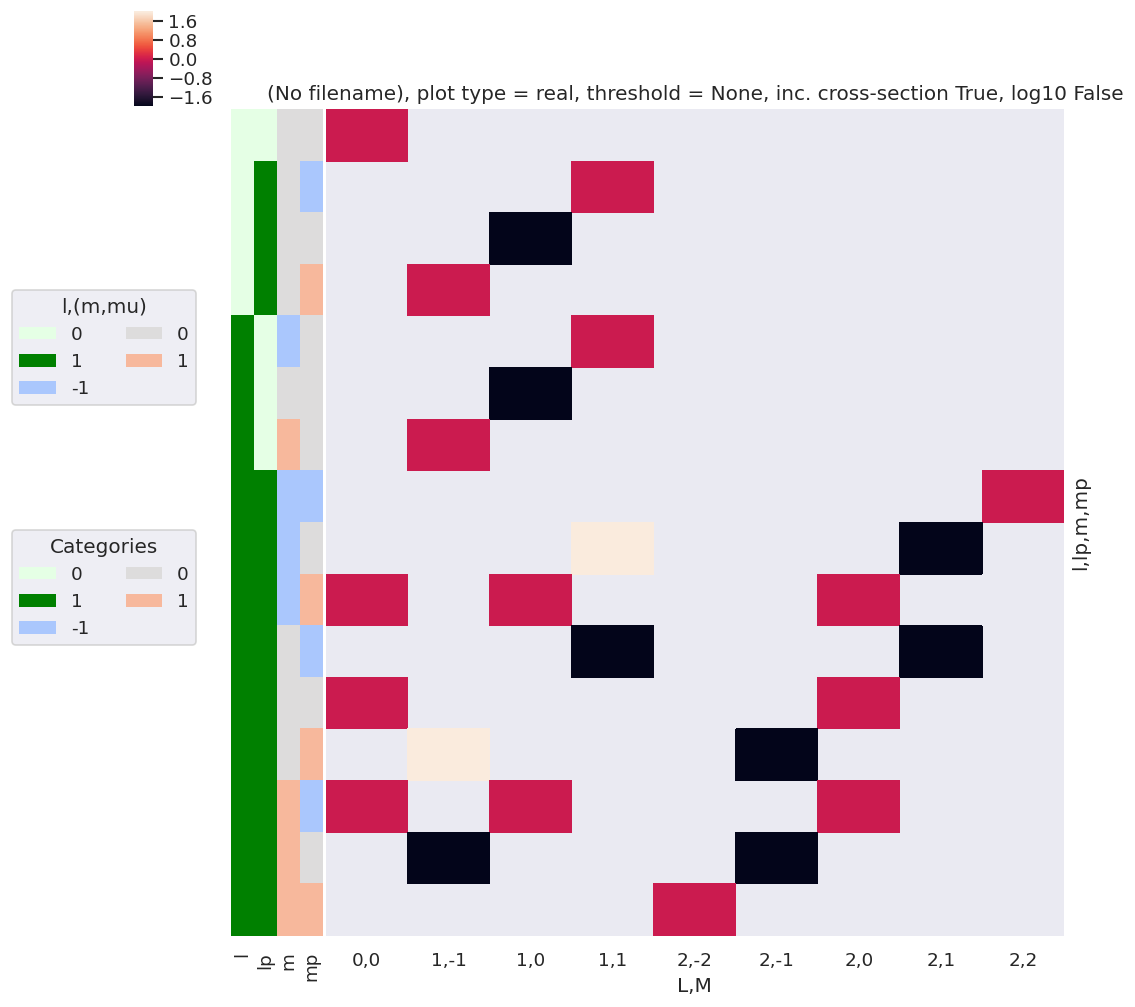

In [51]:
# Compare
daPlot, daPlotpd, legendList, gFig = ep.lmPlot((w3jX - CGX), xDim=xDim, pType = 'r', thres=None)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(np.sign(w3jX) - np.sign(CGX), xDim=xDim, pType = 'r', thres=None)

In [52]:
np.sign(w3jX)

<xarray.DataArray (QN: 25)>
array([ 1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.])
Coordinates:
  * QN       (QN) MultiIndex
  - l        (QN) int64 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - lp       (QN) int64 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - L        (QN) int64 0 1 1 1 1 1 1 2 1 2 0 1 2 1 2 0 2 1 2 0 1 2 1 2 2
  - m        (QN) int64 0 0 0 0 -1 0 1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1
  - mp       (QN) int64 0 -1 0 1 0 0 0 -1 0 0 1 1 1 -1 -1 0 0 1 1 -1 -1 -1 0 0 1
  - M        (QN) int64 0 1 0 -1 1 0 -1 2 1 1 0 0 0 1 1 0 0 -1 -1 0 0 0 -1 -1 -2

In [53]:
np.sign(CGX)

<xarray.DataArray (QN: 25)>
array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
Coordinates:
  * QN       (QN) MultiIndex
  - l        (QN) int64 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - lp       (QN) int64 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - L        (QN) int64 0 1 1 1 1 1 1 2 1 2 0 1 2 1 2 0 2 1 2 0 1 2 1 2 2
  - m        (QN) int64 0 0 0 0 -1 0 1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1
  - mp       (QN) int64 0 -1 0 1 0 0 0 -1 0 0 1 1 1 -1 -1 0 0 1 1 -1 -1 -1 0 0 1
  - M        (QN) int64 0 1 0 -1 1 0 -1 2 1 1 0 0 0 1 1 0 0 -1 -1 0 0 0 -1 -1 -2